In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from torchvision import datasets, transforms, models
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
import time


In [2]:
DEVICE = ('cuda' if torch.cuda.is_available() else 'cpu')
train_csv = pd.read_csv('Dataset/train.csv')
new_train_csv = train_csv.drop('id', axis=1,inplace=False)
new_train_csv = new_train_csv.drop('species', axis=1,inplace=False)

In [3]:
for column in new_train_csv.columns:
    new_train_csv[column] = StandardScaler().fit_transform(new_train_csv[column].values.reshape(-1, 1))

    
features = np.array(new_train_csv.values)
features.shape

(990, 192)

In [4]:
classes = train_csv[['id','species']].copy()
classes['id'] = classes['id'].astype(str)
classes['label'] = LabelEncoder().fit_transform(classes['species'])

image_folder = 'Dataset/images/'
imgs = []
labels = []
for i in sorted(os.listdir(image_folder)):
    id = i.split('.')[0]
    if id in classes['id'].values:
        labels.append(classes[classes['id'] == id]['label'].values[0])
        image = Image.open(os.path.join(image_folder, i)).convert('1')
        imgs.append(image)

print(f"There are {len(imgs)} images in the dataset")
print(f"There are {len(np.unique(labels))} labels in the dataset")

There are 990 images in the dataset
There are 99 labels in the dataset


In [5]:
X_train, X_test, y_train, y_test, features_train, features_test = train_test_split(imgs, labels, features, test_size=0.2, random_state=42, stratify=labels)
print(f"There are {len(X_train)} images in the training set")
print(f"There are {len(X_test)} images in the test set")
print(f"There are {len(np.unique(y_train))} classes in the training set")
print(f"There are {len(np.unique(y_test))} classes in the test set")

There are 792 images in the training set
There are 198 images in the test set
There are 99 classes in the training set
There are 99 classes in the test set


In [6]:
class CNNDataSet(torch.utils.data.Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = self.transform(image=np.array(self.images[index],dtype=np.float32))['image']
        label = torch.tensor(self.labels[index], dtype=torch.long)
        return image, label



transform = A.Compose([
    A.Resize(64, 64),
    ToTensorV2()
])

trainDataSet = CNNDataSet(images=X_train, labels=y_train, transform=transform)
testDataSet = CNNDataSet(images=X_test, labels=y_test, transform=transform)


In [7]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=7, stride=1, padding=3),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Flatten(),
            nn.Linear(256*8*8, 256),
            nn.ReLU(),
            nn.Linear(256, 99),

        ).to(DEVICE)


    def forward(self, x):
        x = self.cnn(x).to(DEVICE)
        return x

In [ ]:
model = CNNModel()
writer = SummaryWriter('runs/cnnArchitecture'+time.strftime("%Y%m%d-%H%M%S"))
writer.add_graph(model, torch.zeros([1,1,64,64]))
writer.close()

In [8]:
batch_size = 8
trainDataLoader = torch.utils.data.DataLoader(trainDataSet, batch_size=batch_size, shuffle=True)
testDataLoader = torch.utils.data.DataLoader(testDataSet, batch_size=batch_size, shuffle=True)

min_loss_epoch = 0
min_loss_value = -1
best_model_weights_paths = {}

best_val_loss = float('inf')  # Initialize with a large value
best_epoch = -1
best_model_weights = None
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []


criterion = nn.CrossEntropyLoss().to(DEVICE)
model = CNNModel().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=3e-5, weight_decay=0.1)
num_epochs = 100

writer = SummaryWriter('runs/cnn/'+time.strftime("%Y%m%d-%H%M%S"))


for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    progress = tqdm(trainDataLoader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")
    correct_predictions = 0
    for images, labels in progress:
        optimizer.zero_grad()
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        progress.set_postfix(loss=loss.item())

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()

    train_loss = running_loss / len(trainDataSet) 
    train_accuracy = correct_predictions / len(trainDataSet)

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    # Validation loop
    model.eval()  
    correct_predictions = 0
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in testDataLoader:
            labels = labels.to(DEVICE)
            images = images.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss +=  loss
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()

    val_accuracy = correct_predictions / len(testDataSet)
    val_loss = val_loss / len(testDataSet)

    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
        best_model = model

    print(f"Epoch: {epoch+1}/{num_epochs}  Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    print(f"Epoch: {epoch+1}/{num_epochs}  Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}")

    writer.add_scalar('Training Loss', train_loss, epoch)
    writer.add_scalar('Validation Loss', val_loss, epoch)
    writer.add_scalar('Training Accuracy', train_accuracy, epoch)
    writer.add_scalar('Validation Accuracy', val_accuracy, epoch)

writer.close()


Epoch 1/100:   0%|          | 0/99 [00:00<?, ?batch/s]

Epoch 1/100: 100%|██████████| 99/99 [00:08<00:00, 11.57batch/s, loss=4.48]


Epoch: 1/100  Train Loss: 0.5324, Val Loss: 0.4431
Epoch: 1/100  Train Accuracy: 0.1010, Val Accuracy: 0.2475


Epoch 2/100: 100%|██████████| 99/99 [00:08<00:00, 12.08batch/s, loss=2.1] 


Epoch: 2/100  Train Loss: 0.3621, Val Loss: 0.3364
Epoch: 2/100  Train Accuracy: 0.4028, Val Accuracy: 0.4141


Epoch 3/100: 100%|██████████| 99/99 [00:07<00:00, 12.90batch/s, loss=1.19] 


Epoch: 3/100  Train Loss: 0.2275, Val Loss: 0.2659
Epoch: 3/100  Train Accuracy: 0.6755, Val Accuracy: 0.5303


Epoch 4/100: 100%|██████████| 99/99 [00:07<00:00, 12.77batch/s, loss=1.17] 


Epoch: 4/100  Train Loss: 0.1344, Val Loss: 0.2283
Epoch: 4/100  Train Accuracy: 0.8586, Val Accuracy: 0.5707


Epoch 5/100: 100%|██████████| 99/99 [00:07<00:00, 12.40batch/s, loss=0.508]


Epoch: 5/100  Train Loss: 0.0721, Val Loss: 0.2007
Epoch: 5/100  Train Accuracy: 0.9583, Val Accuracy: 0.6263


Epoch 6/100: 100%|██████████| 99/99 [00:07<00:00, 12.41batch/s, loss=0.213]


Epoch: 6/100  Train Loss: 0.0380, Val Loss: 0.1812
Epoch: 6/100  Train Accuracy: 0.9912, Val Accuracy: 0.6869


Epoch 7/100: 100%|██████████| 99/99 [00:07<00:00, 13.42batch/s, loss=0.167] 


Epoch: 7/100  Train Loss: 0.0205, Val Loss: 0.1704
Epoch: 7/100  Train Accuracy: 1.0000, Val Accuracy: 0.6919


Epoch 8/100: 100%|██████████| 99/99 [00:07<00:00, 13.49batch/s, loss=0.12]  


Epoch: 8/100  Train Loss: 0.0138, Val Loss: 0.1713
Epoch: 8/100  Train Accuracy: 1.0000, Val Accuracy: 0.7121


Epoch 9/100: 100%|██████████| 99/99 [00:07<00:00, 13.22batch/s, loss=0.111] 


Epoch: 9/100  Train Loss: 0.0109, Val Loss: 0.1654
Epoch: 9/100  Train Accuracy: 1.0000, Val Accuracy: 0.7374


Epoch 10/100: 100%|██████████| 99/99 [00:07<00:00, 13.49batch/s, loss=0.0858]


Epoch: 10/100  Train Loss: 0.0094, Val Loss: 0.1650
Epoch: 10/100  Train Accuracy: 1.0000, Val Accuracy: 0.7323


Epoch 11/100: 100%|██████████| 99/99 [00:07<00:00, 13.26batch/s, loss=0.0905]


Epoch: 11/100  Train Loss: 0.0087, Val Loss: 0.1670
Epoch: 11/100  Train Accuracy: 1.0000, Val Accuracy: 0.7374


Epoch 12/100: 100%|██████████| 99/99 [00:07<00:00, 13.43batch/s, loss=0.0721]


Epoch: 12/100  Train Loss: 0.0081, Val Loss: 0.1689
Epoch: 12/100  Train Accuracy: 1.0000, Val Accuracy: 0.7576


Epoch 13/100: 100%|██████████| 99/99 [00:07<00:00, 13.26batch/s, loss=0.0786]


Epoch: 13/100  Train Loss: 0.0080, Val Loss: 0.1674
Epoch: 13/100  Train Accuracy: 1.0000, Val Accuracy: 0.7424


Epoch 14/100: 100%|██████████| 99/99 [00:07<00:00, 13.27batch/s, loss=0.0683]


Epoch: 14/100  Train Loss: 0.0079, Val Loss: 0.1704
Epoch: 14/100  Train Accuracy: 1.0000, Val Accuracy: 0.7424


Epoch 15/100: 100%|██████████| 99/99 [00:07<00:00, 13.42batch/s, loss=0.0818]


Epoch: 15/100  Train Loss: 0.0080, Val Loss: 0.1711
Epoch: 15/100  Train Accuracy: 1.0000, Val Accuracy: 0.7424


Epoch 16/100: 100%|██████████| 99/99 [00:07<00:00, 13.59batch/s, loss=0.0766]


Epoch: 16/100  Train Loss: 0.0079, Val Loss: 0.1720
Epoch: 16/100  Train Accuracy: 1.0000, Val Accuracy: 0.7475


Epoch 17/100: 100%|██████████| 99/99 [00:07<00:00, 13.16batch/s, loss=0.0623]


Epoch: 17/100  Train Loss: 0.0079, Val Loss: 0.1743
Epoch: 17/100  Train Accuracy: 1.0000, Val Accuracy: 0.7475


Epoch 18/100: 100%|██████████| 99/99 [00:07<00:00, 13.25batch/s, loss=0.0658]


Epoch: 18/100  Train Loss: 0.0081, Val Loss: 0.1730
Epoch: 18/100  Train Accuracy: 1.0000, Val Accuracy: 0.7475


Epoch 19/100: 100%|██████████| 99/99 [00:07<00:00, 13.48batch/s, loss=0.111] 


Epoch: 19/100  Train Loss: 0.0082, Val Loss: 0.1786
Epoch: 19/100  Train Accuracy: 1.0000, Val Accuracy: 0.7576


Epoch 20/100: 100%|██████████| 99/99 [00:07<00:00, 13.05batch/s, loss=0.08]  


Epoch: 20/100  Train Loss: 0.0083, Val Loss: 0.1765
Epoch: 20/100  Train Accuracy: 1.0000, Val Accuracy: 0.7525


Epoch 21/100: 100%|██████████| 99/99 [00:07<00:00, 13.37batch/s, loss=0.0499]


Epoch: 21/100  Train Loss: 0.0084, Val Loss: 0.1759
Epoch: 21/100  Train Accuracy: 1.0000, Val Accuracy: 0.7778


Epoch 22/100: 100%|██████████| 99/99 [00:07<00:00, 13.54batch/s, loss=0.0687]


Epoch: 22/100  Train Loss: 0.0083, Val Loss: 0.1785
Epoch: 22/100  Train Accuracy: 1.0000, Val Accuracy: 0.7677


Epoch 23/100: 100%|██████████| 99/99 [00:07<00:00, 13.46batch/s, loss=0.087] 


Epoch: 23/100  Train Loss: 0.0084, Val Loss: 0.1785
Epoch: 23/100  Train Accuracy: 1.0000, Val Accuracy: 0.7626


Epoch 24/100: 100%|██████████| 99/99 [00:07<00:00, 13.24batch/s, loss=0.114] 


Epoch: 24/100  Train Loss: 0.0084, Val Loss: 0.1824
Epoch: 24/100  Train Accuracy: 1.0000, Val Accuracy: 0.7727


Epoch 25/100: 100%|██████████| 99/99 [00:07<00:00, 13.25batch/s, loss=0.0708]


Epoch: 25/100  Train Loss: 0.0087, Val Loss: 0.1796
Epoch: 25/100  Train Accuracy: 1.0000, Val Accuracy: 0.7727


Epoch 26/100: 100%|██████████| 99/99 [00:07<00:00, 12.99batch/s, loss=0.0932]


Epoch: 26/100  Train Loss: 0.0084, Val Loss: 0.1777
Epoch: 26/100  Train Accuracy: 1.0000, Val Accuracy: 0.7778


Epoch 27/100: 100%|██████████| 99/99 [00:07<00:00, 12.86batch/s, loss=0.0862]


Epoch: 27/100  Train Loss: 0.0086, Val Loss: 0.1777
Epoch: 27/100  Train Accuracy: 1.0000, Val Accuracy: 0.7929


Epoch 28/100: 100%|██████████| 99/99 [00:07<00:00, 13.15batch/s, loss=0.0769]


Epoch: 28/100  Train Loss: 0.0088, Val Loss: 0.1762
Epoch: 28/100  Train Accuracy: 1.0000, Val Accuracy: 0.7576


Epoch 29/100: 100%|██████████| 99/99 [00:07<00:00, 13.36batch/s, loss=0.0683]


Epoch: 29/100  Train Loss: 0.0086, Val Loss: 0.1796
Epoch: 29/100  Train Accuracy: 1.0000, Val Accuracy: 0.7828


Epoch 30/100: 100%|██████████| 99/99 [00:07<00:00, 13.46batch/s, loss=0.0819]


Epoch: 30/100  Train Loss: 0.0090, Val Loss: 0.1850
Epoch: 30/100  Train Accuracy: 1.0000, Val Accuracy: 0.7576


Epoch 31/100: 100%|██████████| 99/99 [00:07<00:00, 13.17batch/s, loss=0.0887]


Epoch: 31/100  Train Loss: 0.0090, Val Loss: 0.1743
Epoch: 31/100  Train Accuracy: 1.0000, Val Accuracy: 0.7828


Epoch 32/100: 100%|██████████| 99/99 [00:07<00:00, 13.27batch/s, loss=0.09]  


Epoch: 32/100  Train Loss: 0.0086, Val Loss: 0.1824
Epoch: 32/100  Train Accuracy: 1.0000, Val Accuracy: 0.7828


Epoch 33/100: 100%|██████████| 99/99 [00:07<00:00, 13.27batch/s, loss=0.0718]


Epoch: 33/100  Train Loss: 0.0090, Val Loss: 0.1784
Epoch: 33/100  Train Accuracy: 1.0000, Val Accuracy: 0.7778


Epoch 34/100: 100%|██████████| 99/99 [00:07<00:00, 13.31batch/s, loss=0.0818]


Epoch: 34/100  Train Loss: 0.0090, Val Loss: 0.1852
Epoch: 34/100  Train Accuracy: 1.0000, Val Accuracy: 0.7879


Epoch 35/100: 100%|██████████| 99/99 [00:07<00:00, 12.63batch/s, loss=0.0745]


Epoch: 35/100  Train Loss: 0.0091, Val Loss: 0.1749
Epoch: 35/100  Train Accuracy: 1.0000, Val Accuracy: 0.7828


Epoch 36/100: 100%|██████████| 99/99 [00:07<00:00, 12.63batch/s, loss=0.0967]


Epoch: 36/100  Train Loss: 0.0092, Val Loss: 0.1801
Epoch: 36/100  Train Accuracy: 1.0000, Val Accuracy: 0.7879


Epoch 37/100: 100%|██████████| 99/99 [00:07<00:00, 13.08batch/s, loss=0.0854]


Epoch: 37/100  Train Loss: 0.0090, Val Loss: 0.1753
Epoch: 37/100  Train Accuracy: 1.0000, Val Accuracy: 0.8081


Epoch 38/100: 100%|██████████| 99/99 [00:07<00:00, 12.74batch/s, loss=0.102] 


Epoch: 38/100  Train Loss: 0.0092, Val Loss: 0.1795
Epoch: 38/100  Train Accuracy: 1.0000, Val Accuracy: 0.7576


Epoch 39/100: 100%|██████████| 99/99 [00:08<00:00, 12.13batch/s, loss=0.122] 


Epoch: 39/100  Train Loss: 0.0094, Val Loss: 0.1824
Epoch: 39/100  Train Accuracy: 1.0000, Val Accuracy: 0.7727


Epoch 40/100: 100%|██████████| 99/99 [00:07<00:00, 12.64batch/s, loss=0.0872]


Epoch: 40/100  Train Loss: 0.0095, Val Loss: 0.1795
Epoch: 40/100  Train Accuracy: 1.0000, Val Accuracy: 0.7929


Epoch 41/100: 100%|██████████| 99/99 [00:08<00:00, 12.20batch/s, loss=0.108] 


Epoch: 41/100  Train Loss: 0.0093, Val Loss: 0.1709
Epoch: 41/100  Train Accuracy: 1.0000, Val Accuracy: 0.7929


Epoch 42/100: 100%|██████████| 99/99 [00:07<00:00, 13.25batch/s, loss=0.113] 


Epoch: 42/100  Train Loss: 0.0093, Val Loss: 0.1813
Epoch: 42/100  Train Accuracy: 1.0000, Val Accuracy: 0.7929


Epoch 43/100: 100%|██████████| 99/99 [00:07<00:00, 13.11batch/s, loss=0.0939]


Epoch: 43/100  Train Loss: 0.0094, Val Loss: 0.1731
Epoch: 43/100  Train Accuracy: 1.0000, Val Accuracy: 0.8081


Epoch 44/100: 100%|██████████| 99/99 [00:07<00:00, 12.74batch/s, loss=0.133] 


Epoch: 44/100  Train Loss: 0.0097, Val Loss: 0.1843
Epoch: 44/100  Train Accuracy: 1.0000, Val Accuracy: 0.7778


Epoch 45/100: 100%|██████████| 99/99 [00:07<00:00, 12.54batch/s, loss=0.0906]


Epoch: 45/100  Train Loss: 0.0094, Val Loss: 0.1795
Epoch: 45/100  Train Accuracy: 1.0000, Val Accuracy: 0.8030


Epoch 46/100: 100%|██████████| 99/99 [00:07<00:00, 12.72batch/s, loss=0.099] 


Epoch: 46/100  Train Loss: 0.0095, Val Loss: 0.1771
Epoch: 46/100  Train Accuracy: 1.0000, Val Accuracy: 0.7828


Epoch 47/100: 100%|██████████| 99/99 [00:08<00:00, 11.72batch/s, loss=0.0915]


Epoch: 47/100  Train Loss: 0.0098, Val Loss: 0.1771
Epoch: 47/100  Train Accuracy: 1.0000, Val Accuracy: 0.7929


Epoch 48/100: 100%|██████████| 99/99 [00:07<00:00, 13.02batch/s, loss=0.0963]


Epoch: 48/100  Train Loss: 0.0094, Val Loss: 0.1820
Epoch: 48/100  Train Accuracy: 1.0000, Val Accuracy: 0.7879


Epoch 49/100: 100%|██████████| 99/99 [00:08<00:00, 12.05batch/s, loss=0.0911]


Epoch: 49/100  Train Loss: 0.0096, Val Loss: 0.1702
Epoch: 49/100  Train Accuracy: 1.0000, Val Accuracy: 0.7828


Epoch 50/100: 100%|██████████| 99/99 [00:08<00:00, 12.27batch/s, loss=0.119] 


Epoch: 50/100  Train Loss: 0.0100, Val Loss: 0.1828
Epoch: 50/100  Train Accuracy: 1.0000, Val Accuracy: 0.7879


Epoch 51/100: 100%|██████████| 99/99 [00:07<00:00, 12.64batch/s, loss=0.0931]


Epoch: 51/100  Train Loss: 0.0097, Val Loss: 0.1854
Epoch: 51/100  Train Accuracy: 1.0000, Val Accuracy: 0.7980


Epoch 52/100: 100%|██████████| 99/99 [00:07<00:00, 13.07batch/s, loss=0.0965]


Epoch: 52/100  Train Loss: 0.0095, Val Loss: 0.1728
Epoch: 52/100  Train Accuracy: 1.0000, Val Accuracy: 0.7778


Epoch 53/100: 100%|██████████| 99/99 [00:07<00:00, 13.04batch/s, loss=0.0997]


Epoch: 53/100  Train Loss: 0.0100, Val Loss: 0.1769
Epoch: 53/100  Train Accuracy: 1.0000, Val Accuracy: 0.8081


Epoch 54/100: 100%|██████████| 99/99 [00:07<00:00, 12.75batch/s, loss=0.0879]


Epoch: 54/100  Train Loss: 0.0096, Val Loss: 0.1674
Epoch: 54/100  Train Accuracy: 1.0000, Val Accuracy: 0.7929


Epoch 55/100: 100%|██████████| 99/99 [00:07<00:00, 12.90batch/s, loss=0.116] 


Epoch: 55/100  Train Loss: 0.0099, Val Loss: 0.1746
Epoch: 55/100  Train Accuracy: 1.0000, Val Accuracy: 0.7576


Epoch 56/100: 100%|██████████| 99/99 [00:07<00:00, 12.66batch/s, loss=0.095] 


Epoch: 56/100  Train Loss: 0.0100, Val Loss: 0.1729
Epoch: 56/100  Train Accuracy: 1.0000, Val Accuracy: 0.7879


Epoch 57/100: 100%|██████████| 99/99 [00:07<00:00, 12.75batch/s, loss=0.113] 


Epoch: 57/100  Train Loss: 0.0100, Val Loss: 0.1792
Epoch: 57/100  Train Accuracy: 1.0000, Val Accuracy: 0.7879


Epoch 58/100: 100%|██████████| 99/99 [00:07<00:00, 13.02batch/s, loss=0.0993]


Epoch: 58/100  Train Loss: 0.0098, Val Loss: 0.1869
Epoch: 58/100  Train Accuracy: 1.0000, Val Accuracy: 0.7980


Epoch 59/100: 100%|██████████| 99/99 [00:07<00:00, 12.97batch/s, loss=0.127] 


Epoch: 59/100  Train Loss: 0.0098, Val Loss: 0.1788
Epoch: 59/100  Train Accuracy: 1.0000, Val Accuracy: 0.7929


Epoch 60/100: 100%|██████████| 99/99 [00:07<00:00, 12.95batch/s, loss=0.115] 


Epoch: 60/100  Train Loss: 0.0097, Val Loss: 0.1837
Epoch: 60/100  Train Accuracy: 1.0000, Val Accuracy: 0.7929


Epoch 61/100: 100%|██████████| 99/99 [00:07<00:00, 12.65batch/s, loss=0.127] 


Epoch: 61/100  Train Loss: 0.0100, Val Loss: 0.1945
Epoch: 61/100  Train Accuracy: 1.0000, Val Accuracy: 0.8131


Epoch 62/100: 100%|██████████| 99/99 [00:07<00:00, 12.95batch/s, loss=0.0929]


Epoch: 62/100  Train Loss: 0.0100, Val Loss: 0.1861
Epoch: 62/100  Train Accuracy: 1.0000, Val Accuracy: 0.7778


Epoch 63/100: 100%|██████████| 99/99 [00:07<00:00, 12.72batch/s, loss=0.0918]


Epoch: 63/100  Train Loss: 0.0098, Val Loss: 0.1851
Epoch: 63/100  Train Accuracy: 1.0000, Val Accuracy: 0.7879


Epoch 64/100: 100%|██████████| 99/99 [00:07<00:00, 13.07batch/s, loss=0.108] 


Epoch: 64/100  Train Loss: 0.0098, Val Loss: 0.1902
Epoch: 64/100  Train Accuracy: 1.0000, Val Accuracy: 0.7980


Epoch 65/100: 100%|██████████| 99/99 [00:07<00:00, 13.07batch/s, loss=0.0926]


Epoch: 65/100  Train Loss: 0.0100, Val Loss: 0.2118
Epoch: 65/100  Train Accuracy: 1.0000, Val Accuracy: 0.7879


Epoch 66/100: 100%|██████████| 99/99 [00:07<00:00, 12.90batch/s, loss=0.105] 


Epoch: 66/100  Train Loss: 0.0099, Val Loss: 0.1731
Epoch: 66/100  Train Accuracy: 1.0000, Val Accuracy: 0.8030


Epoch 67/100: 100%|██████████| 99/99 [00:07<00:00, 13.05batch/s, loss=0.124] 


Epoch: 67/100  Train Loss: 0.0098, Val Loss: 0.2023
Epoch: 67/100  Train Accuracy: 1.0000, Val Accuracy: 0.7980


Epoch 68/100: 100%|██████████| 99/99 [00:07<00:00, 12.85batch/s, loss=0.11]  


Epoch: 68/100  Train Loss: 0.0100, Val Loss: 0.1944
Epoch: 68/100  Train Accuracy: 1.0000, Val Accuracy: 0.7677


Epoch 69/100: 100%|██████████| 99/99 [00:07<00:00, 13.05batch/s, loss=0.0895]


Epoch: 69/100  Train Loss: 0.0102, Val Loss: 0.2049
Epoch: 69/100  Train Accuracy: 1.0000, Val Accuracy: 0.7879


Epoch 70/100: 100%|██████████| 99/99 [00:07<00:00, 12.90batch/s, loss=0.0904]


Epoch: 70/100  Train Loss: 0.0098, Val Loss: 0.1967
Epoch: 70/100  Train Accuracy: 1.0000, Val Accuracy: 0.7778


Epoch 71/100: 100%|██████████| 99/99 [00:07<00:00, 12.96batch/s, loss=0.0819]


Epoch: 71/100  Train Loss: 0.0098, Val Loss: 0.2019
Epoch: 71/100  Train Accuracy: 1.0000, Val Accuracy: 0.8030


Epoch 72/100: 100%|██████████| 99/99 [00:07<00:00, 13.18batch/s, loss=0.106] 


Epoch: 72/100  Train Loss: 0.0096, Val Loss: 0.2003
Epoch: 72/100  Train Accuracy: 1.0000, Val Accuracy: 0.7626


Epoch 73/100: 100%|██████████| 99/99 [00:07<00:00, 13.24batch/s, loss=0.0986]


Epoch: 73/100  Train Loss: 0.0103, Val Loss: 0.1851
Epoch: 73/100  Train Accuracy: 1.0000, Val Accuracy: 0.7727


Epoch 74/100: 100%|██████████| 99/99 [00:08<00:00, 12.24batch/s, loss=0.0923]


Epoch: 74/100  Train Loss: 0.0097, Val Loss: 0.1924
Epoch: 74/100  Train Accuracy: 1.0000, Val Accuracy: 0.7828


Epoch 75/100: 100%|██████████| 99/99 [00:08<00:00, 11.92batch/s, loss=0.0969]


Epoch: 75/100  Train Loss: 0.0097, Val Loss: 0.1927
Epoch: 75/100  Train Accuracy: 1.0000, Val Accuracy: 0.8030


Epoch 76/100: 100%|██████████| 99/99 [00:09<00:00, 10.93batch/s, loss=0.0923]


Epoch: 76/100  Train Loss: 0.0102, Val Loss: 0.1859
Epoch: 76/100  Train Accuracy: 1.0000, Val Accuracy: 0.7929


Epoch 77/100: 100%|██████████| 99/99 [00:08<00:00, 11.87batch/s, loss=0.102] 


Epoch: 77/100  Train Loss: 0.0100, Val Loss: 0.1925
Epoch: 77/100  Train Accuracy: 1.0000, Val Accuracy: 0.7879


Epoch 78/100: 100%|██████████| 99/99 [00:07<00:00, 12.45batch/s, loss=0.0991]


Epoch: 78/100  Train Loss: 0.0097, Val Loss: 0.1952
Epoch: 78/100  Train Accuracy: 1.0000, Val Accuracy: 0.7980


Epoch 79/100: 100%|██████████| 99/99 [00:07<00:00, 12.89batch/s, loss=0.0938]


Epoch: 79/100  Train Loss: 0.0100, Val Loss: 0.1799
Epoch: 79/100  Train Accuracy: 1.0000, Val Accuracy: 0.7879


Epoch 80/100: 100%|██████████| 99/99 [00:07<00:00, 12.93batch/s, loss=0.115] 


Epoch: 80/100  Train Loss: 0.0100, Val Loss: 0.2011
Epoch: 80/100  Train Accuracy: 1.0000, Val Accuracy: 0.8030


Epoch 81/100: 100%|██████████| 99/99 [00:07<00:00, 12.94batch/s, loss=0.0936]


Epoch: 81/100  Train Loss: 0.0102, Val Loss: 0.2099
Epoch: 81/100  Train Accuracy: 1.0000, Val Accuracy: 0.7727


Epoch 82/100: 100%|██████████| 99/99 [00:07<00:00, 12.81batch/s, loss=0.105] 


Epoch: 82/100  Train Loss: 0.0100, Val Loss: 0.1947
Epoch: 82/100  Train Accuracy: 1.0000, Val Accuracy: 0.7980


Epoch 83/100: 100%|██████████| 99/99 [00:07<00:00, 12.89batch/s, loss=0.106] 


Epoch: 83/100  Train Loss: 0.0098, Val Loss: 0.1794
Epoch: 83/100  Train Accuracy: 1.0000, Val Accuracy: 0.7626


Epoch 84/100: 100%|██████████| 99/99 [00:08<00:00, 12.35batch/s, loss=0.0975]


Epoch: 84/100  Train Loss: 0.0099, Val Loss: 0.2103
Epoch: 84/100  Train Accuracy: 1.0000, Val Accuracy: 0.7879


Epoch 85/100: 100%|██████████| 99/99 [00:07<00:00, 12.61batch/s, loss=0.0749]


Epoch: 85/100  Train Loss: 0.0099, Val Loss: 0.1968
Epoch: 85/100  Train Accuracy: 1.0000, Val Accuracy: 0.7828


Epoch 86/100: 100%|██████████| 99/99 [00:07<00:00, 12.45batch/s, loss=0.0895]


Epoch: 86/100  Train Loss: 0.0097, Val Loss: 0.1884
Epoch: 86/100  Train Accuracy: 1.0000, Val Accuracy: 0.7929


Epoch 87/100: 100%|██████████| 99/99 [00:07<00:00, 12.92batch/s, loss=0.101] 


Epoch: 87/100  Train Loss: 0.0098, Val Loss: 0.1920
Epoch: 87/100  Train Accuracy: 1.0000, Val Accuracy: 0.7576


Epoch 88/100: 100%|██████████| 99/99 [00:08<00:00, 12.37batch/s, loss=0.094] 


Epoch: 88/100  Train Loss: 0.0099, Val Loss: 0.1994
Epoch: 88/100  Train Accuracy: 1.0000, Val Accuracy: 0.7828


Epoch 89/100: 100%|██████████| 99/99 [00:07<00:00, 12.61batch/s, loss=0.0979]


Epoch: 89/100  Train Loss: 0.0102, Val Loss: 0.2089
Epoch: 89/100  Train Accuracy: 1.0000, Val Accuracy: 0.7576


Epoch 90/100: 100%|██████████| 99/99 [00:08<00:00, 12.03batch/s, loss=0.0829]


Epoch: 90/100  Train Loss: 0.0101, Val Loss: 0.2133
Epoch: 90/100  Train Accuracy: 1.0000, Val Accuracy: 0.7626


Epoch 91/100: 100%|██████████| 99/99 [00:07<00:00, 12.84batch/s, loss=0.0928]


Epoch: 91/100  Train Loss: 0.0098, Val Loss: 0.1928
Epoch: 91/100  Train Accuracy: 1.0000, Val Accuracy: 0.7778


Epoch 92/100: 100%|██████████| 99/99 [00:08<00:00, 12.34batch/s, loss=0.103] 


Epoch: 92/100  Train Loss: 0.0098, Val Loss: 0.1891
Epoch: 92/100  Train Accuracy: 1.0000, Val Accuracy: 0.7727


Epoch 93/100: 100%|██████████| 99/99 [00:07<00:00, 12.66batch/s, loss=0.0965]


Epoch: 93/100  Train Loss: 0.0099, Val Loss: 0.2321
Epoch: 93/100  Train Accuracy: 1.0000, Val Accuracy: 0.7727


Epoch 94/100: 100%|██████████| 99/99 [00:07<00:00, 12.88batch/s, loss=0.0899]


Epoch: 94/100  Train Loss: 0.0097, Val Loss: 0.2005
Epoch: 94/100  Train Accuracy: 1.0000, Val Accuracy: 0.7879


Epoch 95/100: 100%|██████████| 99/99 [00:07<00:00, 12.57batch/s, loss=0.135] 


Epoch: 95/100  Train Loss: 0.0103, Val Loss: 0.2468
Epoch: 95/100  Train Accuracy: 1.0000, Val Accuracy: 0.7828


Epoch 96/100: 100%|██████████| 99/99 [00:07<00:00, 12.62batch/s, loss=0.1]   


Epoch: 96/100  Train Loss: 0.0104, Val Loss: 0.2025
Epoch: 96/100  Train Accuracy: 1.0000, Val Accuracy: 0.7576


Epoch 97/100: 100%|██████████| 99/99 [00:07<00:00, 12.63batch/s, loss=0.103] 


Epoch: 97/100  Train Loss: 0.0101, Val Loss: 0.2026
Epoch: 97/100  Train Accuracy: 1.0000, Val Accuracy: 0.7576


Epoch 98/100: 100%|██████████| 99/99 [00:08<00:00, 12.07batch/s, loss=0.0987]


Epoch: 98/100  Train Loss: 0.0097, Val Loss: 0.2064
Epoch: 98/100  Train Accuracy: 1.0000, Val Accuracy: 0.7677


Epoch 99/100: 100%|██████████| 99/99 [00:07<00:00, 12.68batch/s, loss=0.0937]


Epoch: 99/100  Train Loss: 0.0097, Val Loss: 0.2188
Epoch: 99/100  Train Accuracy: 1.0000, Val Accuracy: 0.7576


Epoch 100/100: 100%|██████████| 99/99 [00:07<00:00, 12.91batch/s, loss=0.103] 


Epoch: 100/100  Train Loss: 0.0105, Val Loss: 0.2078
Epoch: 100/100  Train Accuracy: 1.0000, Val Accuracy: 0.7677


In [ ]:
print("For CNN Model:")
print(f"Best validation loss: {best_val_loss:.4f} at epoch {best_epoch+1}")
print(f"Best training loss: {train_losses.max():.4f} at epoch {train_losses.argmax()+1}")
print(f"Best validation accuracy: {val_accuracies.max():.4f} at epoch {val_accuracies.argmax()+1}")
print(f"Best training accuracy: {train_accuracies.max():.4f} at epoch {train_accuracies.argmax()+1}")

In [13]:
best_model.eval()
all_labels = []
all_predictions = []
criterion = nn.CrossEntropyLoss()

with torch.no_grad():
    loss = 0.0
    for images, labels in testDataLoader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = best_model(images)
        _, predicted = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        # Convert to numpy arrays
        predicted_np = predicted.cpu().numpy()
        labels_np = labels.cpu().numpy()
        loss += loss.item()
        # Append to the lists
        all_labels.extend(labels_np)
        all_predictions.extend(predicted_np)

val_loss = loss / len(testDataSet)
print(f"Validation Loss: {val_loss*100:.4f}%")
print(f"Validation Accuracy: {accuracy_score(all_labels, all_predictions)*100:.4f}%")

# Create confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
class_names = [str(i) for i in range(len(conf_matrix))]
sns.heatmap(conf_matrix, annot=False, fmt="g", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('CNN only Model Confusion Matrix')
plt.show()

ValueError: too many values to unpack (expected 2)

In [10]:
class CNNFeaturesDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels, features, transform=None):
        self.images = images
        self.labels = labels
        self.features = features
        self.transform = transform


    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = self.transform(image=np.array(self.images[index],dtype=np.float32))['image']
        label = torch.tensor(self.labels[index], dtype=torch.long)
        feature = torch.tensor(np.array(self.features[index],dtype=np.float32), dtype=torch.long)
        return image, label, feature
    

transform = A.Compose([
    A.Resize(64, 64),
    ToTensorV2()
])

trainDataSet = CNNFeaturesDataset(images=X_train, labels=y_train, features= features_train, transform=transform)
testDataSet = CNNFeaturesDataset(images=X_test, labels=y_test, features=features_test, transform=transform)

In [11]:
class CNNFeaturesModel(nn.Module):
    def __init__(self):
        super(CNNFeaturesModel, self).__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=7, stride=1, padding=3),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Flatten(),

        ).to(DEVICE)

        self.linear = nn.Sequential(
            
            nn.Linear(256 * 8 * 8 + 192, 256),
            nn.ReLU(),
            nn.Linear(256, 99),

        ).to(DEVICE)


    def forward(self, x, features):
        x = self.cnn(x).to(DEVICE)
        concat = torch.cat((x, features), dim = 1)
        x = self.linear(concat).to(DEVICE)

        return x


In [ ]:
model = CNNModel()
writer = SummaryWriter('runs/cnn+featuresArchitecture'+time.strftime("%Y%m%d-%H%M%S"))
writer.add_graph(model, torch.zeros([1,1,64,64]))
writer.close()

In [12]:
batch_size = 8
trainDataLoader = torch.utils.data.DataLoader(trainDataSet, batch_size=batch_size, shuffle=True)
testDataLoader = torch.utils.data.DataLoader(testDataSet, batch_size=batch_size, shuffle=True)

min_loss_epoch = 0
min_loss_value = -1
best_model_weights_paths = {}

best_val_loss = float('inf')  # Initialize with a large value
best_epoch = -1
best_model_weights = None
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []


criterion = nn.CrossEntropyLoss().to(DEVICE)
model = CNNFeaturesModel().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=3e-5, weight_decay=0.1)
num_epochs = 100

writer = SummaryWriter('runs/cnn+features/'+time.strftime("%Y%m%d-%H%M%S"))


for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    progress = tqdm(trainDataLoader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")
    correct_predictions = 0
    for images, labels, features in progress:
        optimizer.zero_grad()
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        features = features.to(DEVICE)
        outputs = model(images, features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        progress.set_postfix(loss=loss.item())

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()

    train_loss = running_loss / len(trainDataSet) 
    train_accuracy = correct_predictions / len(trainDataSet)

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    # Validation loop
    model.eval()  
    correct_predictions = 0
    val_loss = 0.0
    with torch.no_grad():
        for images, labels, features in testDataLoader:
            labels = labels.to(DEVICE)
            images = images.to(DEVICE)
            features = features.to(DEVICE)
            outputs = model(images, features)
            loss = criterion(outputs, labels)

            val_loss +=  loss
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()

    val_accuracy = correct_predictions / len(testDataSet)
    val_loss = val_loss / len(testDataSet)

    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
        best_model = model

    print(f"Epoch: {epoch+1}/{num_epochs}  Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    print(f"Epoch: {epoch+1}/{num_epochs}  Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}")

    writer.add_scalar('Training Loss', train_loss, epoch)
    writer.add_scalar('Validation Loss', val_loss, epoch)
    writer.add_scalar('Training Accuracy', train_accuracy, epoch)
    writer.add_scalar('Validation Accuracy', val_accuracy, epoch)

writer.close()

Epoch 1/100:   0%|          | 0/99 [00:00<?, ?batch/s]

Epoch 1/100: 100%|██████████| 99/99 [00:07<00:00, 13.35batch/s, loss=3.97]


Epoch: 1/100  Train Loss: 0.5331, Val Loss: 0.4549
Epoch: 1/100  Train Accuracy: 0.1023, Val Accuracy: 0.2323


Epoch 2/100: 100%|██████████| 99/99 [00:07<00:00, 12.39batch/s, loss=3.05]


Epoch: 2/100  Train Loss: 0.3631, Val Loss: 0.3448
Epoch: 2/100  Train Accuracy: 0.3914, Val Accuracy: 0.3687


Epoch 3/100:  11%|█         | 11/99 [00:00<00:07, 11.94batch/s, loss=2.6] 
[E thread_pool.cpp:110] Exception in thread pool task: mutex lock failed: Invalid argument
[E thread_pool.cpp:110] Exception in thread pool task: mutex lock failed: Invalid argument
[E thread_pool.cpp:110] Exception in thread pool task: mutex lock failed: Invalid argument
[E thread_pool.cpp:110] Exception in thread pool task: mutex lock failed: Invalid argument
[E thread_pool.cpp:110] Exception in thread pool task: mutex lock failed: Invalid argument


KeyboardInterrupt: 

In [ ]:
print("For CNN+Features Model:")
print(f"Best validation loss: {best_val_loss:.4f} at epoch {best_epoch+1}")
print(f"Best training loss: {train_losses.max():.4f} at epoch {train_losses.argmax()+1}")
print(f"Best validation accuracy: {val_accuracies.max():.4f} at epoch {val_accuracies.argmax()+1}")
print(f"Best training accuracy: {train_accuracies.max():.4f} at epoch {train_accuracies.argmax()+1}")

Validation Loss: 1.3215%
Validation Accuracy: 75.7576%


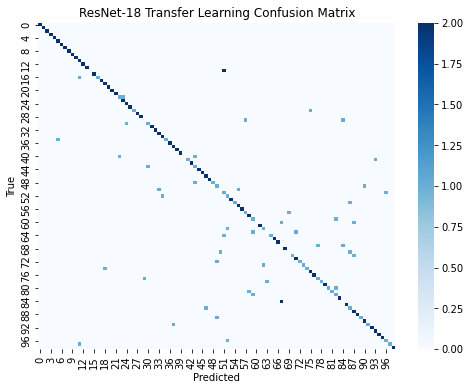

In [ ]:
best_model.eval()
all_labels = []
all_predictions = []
criterion = nn.CrossEntropyLoss()

with torch.no_grad():
    loss = 0.0
    for images, labels, features in testDataLoader:
        labels = labels.to(DEVICE)
        images = images.to(DEVICE)
        features = features.to(DEVICE)
        outputs = best_model(images, features)
        _, predicted = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        # Convert to numpy arrays
        predicted_np = predicted.cpu().numpy()
        labels_np = labels.cpu().numpy()
        loss += loss.item()
        # Append to the lists
        all_labels.extend(labels_np)
        all_predictions.extend(predicted_np)

val_loss = loss / len(testDataSet)
print(f"Validation Loss: {val_loss*100:.4f}%")
print(f"Validation Accuracy: {accuracy_score(all_labels, all_predictions)*100:.4f}%")

# Create confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
class_names = [str(i) for i in range(len(conf_matrix))]
sns.heatmap(conf_matrix, annot=False, fmt="g", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('CNN + Features Confusion Matrix')
plt.show()